In [17]:
from tokenizer import Tokenizer
from data_layer import make_loader
from encoder import ConvRowEncoder, ConvEncoder
from utils import clean_csvs
import pandas as pd
from IPython.display import display, Math
import matplotlib.pyplot as plt
import torch

In [18]:
#clean_csvs()

# Tokenizer

In [19]:
df = pd.read_csv('../data/im2latex_formulas.norm.csv')
formulas = df['formulas'].tolist()

In [20]:
tokenizer = Tokenizer()
tokenizer.build_vocab(formulas)
print('Vocab size:', tokenizer.vocab_size)

Vocab size: 532


In [21]:
s = formulas[0]
ids = tokenizer.encode(s)
display('Original seq', Math(s))
print('ids:', ids)
display('Decoded seq', Math(tokenizer.decode(ids)))

'Original seq'

<IPython.core.display.Math object>

ids: [1, 70, 6, 5, 12, 100, 4, 7, 5, 118, 4, 24, 40, 159, 59, 5, 29, 4, 7, 5, 12, 40, 146, 4, 70, 6, 5, 12, 100, 4, 7, 5, 118, 4, 24, 40, 7, 5, 48, 4, 59, 5, 29, 4, 7, 5, 12, 40, 7, 5, 48, 4, 146, 4, 40, 40, 7, 5, 48, 4, 5, 16, 5, 40, 7, 5, 48, 4, 12, 40, 4, 5, 40, 15, 40, 7, 5, 48, 4, 4, 4, 113, 35, 25, 64, 7, 5, 48, 48, 4, 8, 40, 9, 12, 5, 16, 5, 35, 4, 5, 44, 4, 4, 36, 25, 64, 8, 40, 9, 119, 13, 19, 23, 2]


'Decoded seq'

<IPython.core.display.Math object>

# Data Layer

In [22]:
train_loader = make_loader(
  csv_path = '../data/cleaned_train.csv',
  root_dir = '../data/images',
  tokenizer = tokenizer,
  batch_size = 20,
  shuffle = True,
  img_height = 64
)

In [23]:
# Take a couple of batches and inspect
for i, batch in enumerate(train_loader):
    images = batch["images"]
    print(f"batch {i}: images.shape = {images.shape}")
    if i == 3:
        break


batch 0: images.shape = torch.Size([20, 1, 64, 768])
batch 1: images.shape = torch.Size([20, 1, 64, 512])
batch 2: images.shape = torch.Size([20, 1, 64, 480])
batch 3: images.shape = torch.Size([20, 1, 64, 640])


In [24]:
batch = next(iter(train_loader))

In [25]:
def visualize_batch(batch, tokenizer, max_items=10):
    images      = batch["images"]
    input_ids   = batch["input_ids"]
    target_ids  = batch["target_ids"]
    formulas    = batch["formulas"]

    B = images.shape[0]
    n = min(B, max_items)

    pad_id = tokenizer.token2id[tokenizer.pad_token]

    def strip_pad(seq):
        if pad_id in seq:
            return seq[:seq.index(pad_id)]
        return seq

    cols = 5
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))

    for i in range(n):
        img = images[i].squeeze(0).cpu().numpy()

        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Item {i}")

    plt.suptitle("Batch Images")
    plt.tight_layout()
    plt.show()

    for i in range(n):
        in_ids_list  = strip_pad(input_ids[i].cpu().tolist())
        tgt_ids_list = strip_pad(target_ids[i].cpu().tolist())

        decoded_in   = tokenizer.decode(in_ids_list, remove_special=True)
        decoded_tgt  = tokenizer.decode(tgt_ids_list, remove_special=True)

        print("\n==============================")
        print(f"Item {i}")
        print("Formula:         ", formulas[i])
        print("Input IDs:       ", in_ids_list)
        print("Decoded input:   ", decoded_in)
        print("Target IDs:      ", tgt_ids_list)
        print("Decoded target:  ", decoded_tgt)
    print("==============================\n")


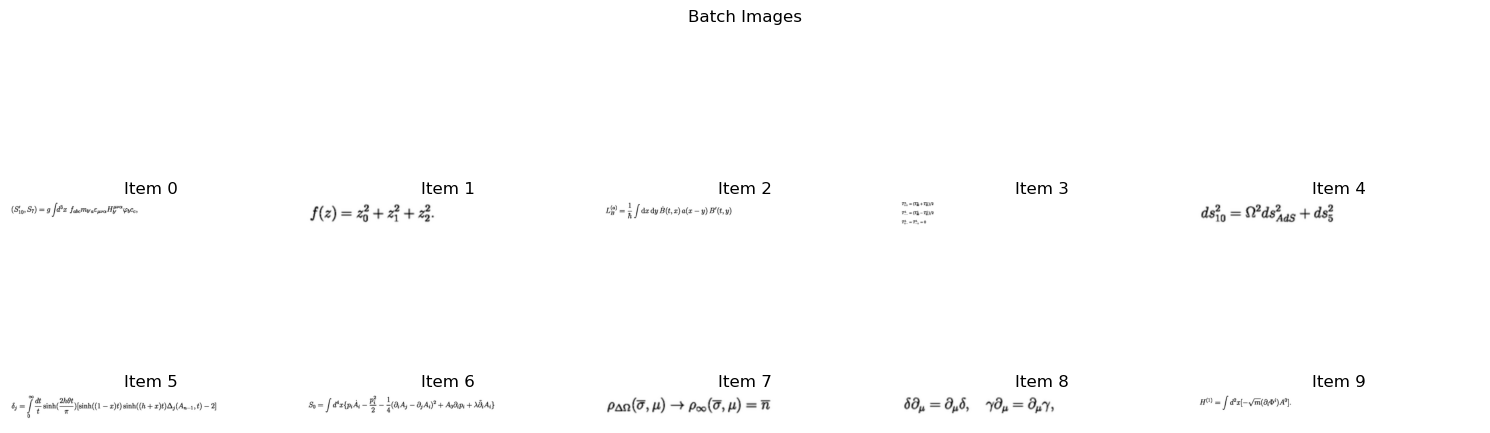


Item 0
Formula:          ( S _ { 1 0 } ^ { \prime } , S _ { 7 } ) = g \int \! \! d ^ { 3 } x ~ f _ { a b c } m _ { b ^ { \prime } a } \varepsilon _ { \mu \nu \alpha } H _ { b ^ { \prime } } ^ { \mu \nu \alpha } \varphi _ { b } c _ { c } ,
Input IDs:        [1, 8, 73, 6, 5, 11, 19, 4, 7, 5, 48, 4, 14, 73, 6, 5, 157, 4, 9, 13, 47, 70, 134, 134, 24, 7, 5, 35, 4, 21, 39, 65, 6, 5, 17, 56, 31, 4, 32, 6, 5, 56, 7, 5, 48, 4, 17, 4, 147, 6, 5, 26, 51, 37, 4, 88, 6, 5, 56, 7, 5, 48, 4, 4, 7, 5, 26, 51, 37, 4, 128, 6, 5, 56, 4, 31, 6, 5, 31, 4, 14]
Decoded input:    (S_{10}^{\prime},S_{7})=g\int\!\!d^{3}x~f_{abc}m_{b^{\prime}a}\varepsilon_{\mu\nu\alpha}H_{b^{\prime}}^{\mu\nu\alpha}\varphi_{b}c_{c},
Target IDs:       [8, 73, 6, 5, 11, 19, 4, 7, 5, 48, 4, 14, 73, 6, 5, 157, 4, 9, 13, 47, 70, 134, 134, 24, 7, 5, 35, 4, 21, 39, 65, 6, 5, 17, 56, 31, 4, 32, 6, 5, 56, 7, 5, 48, 4, 17, 4, 147, 6, 5, 26, 51, 37, 4, 88, 6, 5, 56, 7, 5, 48, 4, 4, 7, 5, 26, 51, 37, 4, 128, 6, 5, 56, 4, 31, 6, 5, 31, 4, 14

In [26]:
visualize_batch(batch, tokenizer, max_items = 10)

# CNN Encoder

In [32]:
images = batch['images']

In [45]:
def vis_enc(encoder, images = images):
  with torch.no_grad():
    feat = encoder.encoder(images)
    out = encoder(images)
  B, C, Hp, Wp = feat.shape
  print(f'CNN feat: {feat.shape}\nenc_out: {out.shape}')

  plt.figure(figsize = (8, 4))
  plt.imshow(feat[0].mean(dim = 0), cmap = 'viridis')
  plt.colorbar()
  plt.show()

  norms = out[0].norm(dim = 1)
  norms_2d = norms.view(Hp, Wp)

  plt.figure(figsize = (8, 4))
  plt.imshow(norms_2d, cmap = 'viridis')
  plt.colorbar()
  plt.show()

In [ ]:
#enc = ConvEncoder(256)
enc = ConvRowEncoder(256)

CNN feat: torch.Size([20, 512, 16, 160])
enc_out: torch.Size([20, 2560, 512])


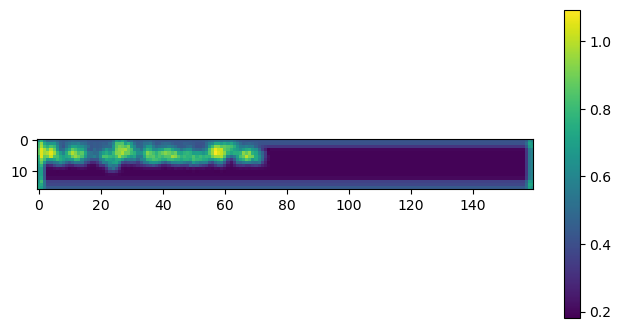

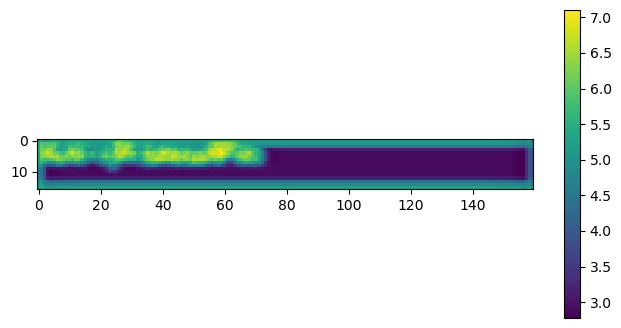

In [47]:
vis_enc(enc, images)